In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=64
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(r"D:\project dataset\DATASET\Corn",shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE)

Found 16261 files belonging to 5 classes.


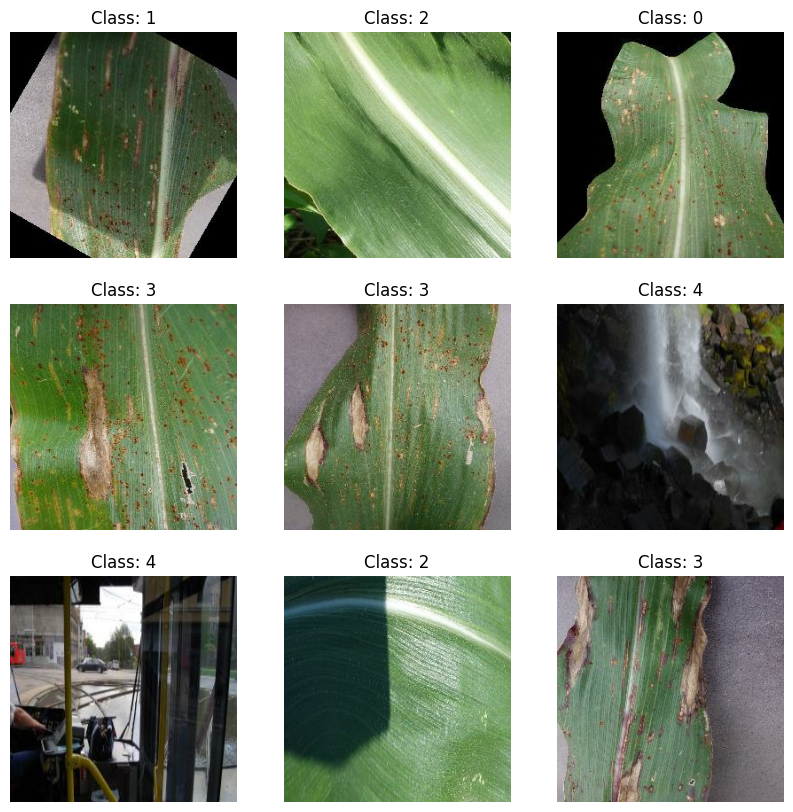

In [4]:
for images, labels in dataset.take(1):

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis("off")

    plt.show()

In [5]:
shuffle_size=1000
suffle_ds=dataset.shuffle(shuffle_size,seed=12)

In [6]:
train_size=0.8

In [7]:
#train 80%
#validate 10%
#test 10%

In [8]:
train_data=int(len(dataset)*train_size)
train_dataset=dataset.take(train_data)
test_dataset=dataset.skip(train_data)

In [9]:
val_size=int((len(test_dataset)/2))

In [10]:
val_dataset=test_dataset.take(val_size)
test_dataset=test_dataset.skip(val_size)

In [11]:
# print(len(dataset))
# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))

In [12]:
train_dataset=train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_rescale=tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    #layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
])

In [15]:
#augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [16]:
#validation_dataset = val_dataset.map(lambda x, y: (resize_rescale(x), y))

In [17]:
#test_dataset = test_dataset.map(lambda x, y: (resize_rescale(x), y))

In [18]:
for batch in train_dataset.take(1):
    images, labels = batch
    print("Shape of images in a batch:", images.shape)

Shape of images in a batch: (64, 256, 256, 3)


In [19]:
n_class=5
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model=models.Sequential([resize_rescale,data_augmentation,layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
                         layers.MaxPooling2D((2,2)),
                         layers.Flatten(),
                         layers.Dense(64,activation='relu'),
                         layers.Dense(n_class,activation='softmax'),
                        ])
model.build(input_shape=input_shape)

In [20]:
model.compile(
             optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [21]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=20,
)

Epoch 1/20
204/204 [==============================] - 586s 3s/step - loss: 0.7526 - accuracy: 0.6746 - val_loss: 0.3201 - val_accuracy: 0.8788
Epoch 2/20
204/204 [==============================] - 488s 2s/step - loss: 0.4091 - accuracy: 0.8346 - val_loss: 0.3416 - val_accuracy: 0.8719
Epoch 3/20
204/204 [==============================] - 484s 2s/step - loss: 0.3536 - accuracy: 0.8618 - val_loss: 0.3806 - val_accuracy: 0.8725
Epoch 4/20
204/204 [==============================] - 486s 2s/step - loss: 0.2675 - accuracy: 0.8935 - val_loss: 0.2325 - val_accuracy: 0.9206
Epoch 5/20
204/204 [==============================] - 518s 3s/step - loss: 0.2524 - accuracy: 0.9016 - val_loss: 0.1614 - val_accuracy: 0.9450
Epoch 6/20
204/204 [==============================] - 485s 2s/step - loss: 0.2304 - accuracy: 0.9110 - val_loss: 0.2138 - val_accuracy: 0.9262
Epoch 7/20
204/204 [==============================] - 489s 2s/step - loss: 0.2204 - accuracy: 0.9158 - val_loss: 0.2596 - val_accuracy: 0.9131

In [22]:
class_names = dataset.class_names
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Leaf_Blight',
 'Invalid']

In [23]:
def evaluate_model(model, test_dataset):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        predictions = model.predict(images)
        y_true.extend(labels)
        y_pred.extend(predictions.argmax(axis=1))

    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')


def plot_confusion_matrix(model, test_dataset,class_names):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        predictions = model.predict(images)
        y_true.extend(labels)
        y_pred.extend(predictions.argmax(axis=1))

    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    #labels = [str(i) for i in range(n_class)]  # Assuming classes are labeled 0, 1, 2, ...
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

2/2 [==============================] - 1s 281ms/step


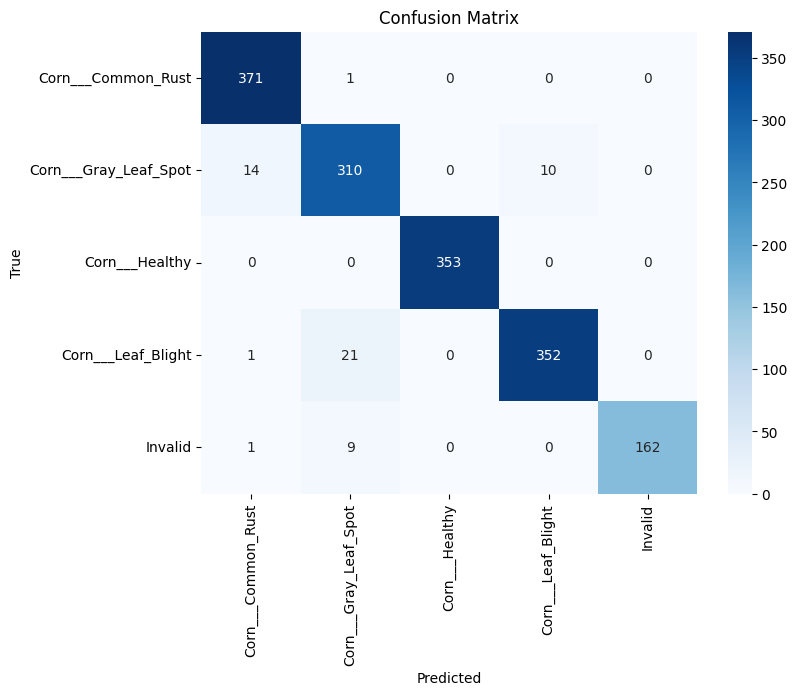

2/2 [==============================] - 1s 267ms/step
Precision: 0.9644859813084112
Recall: 0.9644859813084112
F1 Score: 0.9644859813084112
Accuracy: 0.9644859813084112


In [24]:
plot_confusion_matrix(model, test_dataset,class_names)
evaluate_model(model, test_dataset)

In [25]:
#import numpy as np
#for image_batch,label_batch in test_dataset.take(1):
 #   batch_predict=model.predict(image_batch)

 #   print(batch_predict[0])

 # first_label=label_batch[0].numpy()

 #print("actual Label: ",class_names[first_label])
#print("predicted Label: ",class_names[np.argmax(batch_predict[0])])
#print("Confidence Label: ",np.argmax(batch_predict[0]))

In [26]:
#len(history.history['accuracy'])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


(-0.5, 255.5, 255.5, -0.5)

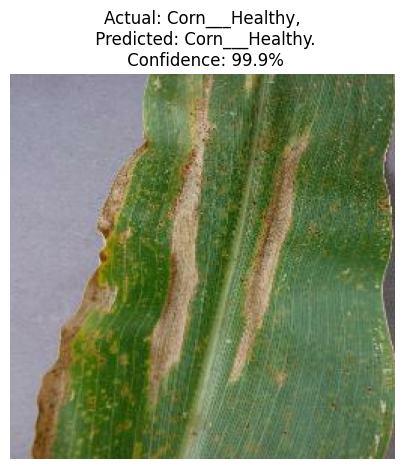

In [28]:
        class_names = dataset.class_names

        plt.figure(figsize=(5, 5))
  #  for images, labels in test_dataset.take(1):
   # for i in range(9):
   #     ax = plt.subplot(3, 3, i + 1)
    
        plt.imshow(images[5].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [29]:
#model_version=2
#model.save(f"C:/Users/user/jupiter/Crop___DIsease/model/{model_version}")

In [30]:
model_version=3
model.save(f"C:\\Users\\User\\Downloads\\Project\\project model\\corn/{model_version}")

INFO:tensorflow:Assets written to: C:\Users\User\Downloads\Project\project model\corn/3\assets


INFO:tensorflow:Assets written to: C:\Users\User\Downloads\Project\project model\corn/3\assets


In [31]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_1 = converter.convert()

with open(f"C:\\Users\\User\\Downloads\\Project\\project model\\corn/{model_version}/corn_model.tflite", 'wb') as f:
  f.write(tflite_model_1)
   

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp36eyhrwz\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp36eyhrwz\assets
